In [1]:
# import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

In [ ]:
os.chdir("/mnt/")

In [3]:
!git clone https://github.com/Annaantonin/Data.git

fatal: destination path 'Data' already exists and is not an empty directory.


In [3]:
import Data as data

In [ ]:
!git clone https://github.com/Crunch-UQ4MI/neuraluq.git
#!git clone https://github.com/Annaantonin/Data.git
!pip install tensorflow-probability
!pip install scipy
import os
os.chdir("/tf/neuraluq/")
!python setup.py install

In [7]:
os.listdir(".")

['dataset',
 'README.md',
 'dist',
 'build',
 'output.mat',
 'examples',
 'NeuralUQ.egg-info',
 'output_ukF.mat',
 '.git',
 'setup.py',
 'Data',
 'neuraluq']

In [6]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
from scipy.io import loadmat

import matplotlib.pyplot as plt

In [52]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  4 16:14:30 2023

@author: Antonina
"""

#%%
# Simulated SDOF with:
# % SDOF System Parameters
# m = 5.0;       % Mass (kg)
# k = 10.0;     % Stiffness (N/m)
# c = 0.22;      % Damping coefficient (Ns/m)
# dt=0.001

def load_data(noise_x, noise_f):

    #data = sio.loadmat(r"G:\My Drive\Python_codes\NNs\sdof_ymeas.mat")
    data = sio.loadmat("Data/sdof_2000.mat")
    #  t_x_train, t_f_train = data["t"], data["ymeas"]
    # data = matdata['data']
    
    x_tt_train, t_train = data["a"], data["t"]
    x_train, f_train = data["u"], data["force"]
    # train_x_tt = t_x_tt_train, x_train
    # train_f = t_f_train, f_train

    return  x_tt_train.T, t_train.T, x_train.T, f_train.T

#m=1
# [0][..., 0:1]     
def pde_fn(t, x, f, log_c, log_k):
    # log_k=tf.cli_pby_value(np.log(3),np.log(20)) # to make constrains for the parameters
    x_t = tf.gradients(x, t)     # velocity automatic differentiation                                                                                                                                                                                                                        
    # x_tt = tf.gradients(x_t, t)

    # x_tt=f - tf.multiply(x_tt, 5.0)+ tf.exp(log_c) * x_t + tf.exp(log_k) * x
    x_tt=(f - (tf.exp(log_c) * x_t + tf.exp(log_k) * x))
    # return [f,x_tt]
    
    return tf.multiply(x_tt, 0.20)

def pde_xtt(t,x):
    x_t = tf.gradients(x, t)                                                                                                                                                                                                                        
    x_tt = tf.gradients(x_t, t)
    return x_tt
    
@neuq.utils.timer
def Trainable(
    x_tt_train, t_train, x_train, f_train, noise, layers, layers_force
):
    # build processes
    process_f = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers_force),  #, activation=tf.sigmoid
        posterior=neuq_vars.fnn.Trainable( layers=layers_force ), #, regularizer=tf.keras.regularizers.l2(1e-5)
            )
    process_x = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        # surrogate=neuq.surrogates.FNN(layers=layers,activation=RELu),
        posterior=neuq_vars.fnn.Trainable(layers=layers),# predicted displacement
    )
    process_log_c = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_log_k = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    method = neuq.inferences.DEns(
        num_samples=10, num_iterations=10000, optimizer=tf.train.AdamOptimizer(1e-3),
    )

    # build losses
    loss_x = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train, # could be the problem
        processes=[process_x],
        pde=pde_xtt, # dotdot _X
        multiplier=1.0,
    )
    
    loss_f = neuq.likelihoods.MSE(
        inputs=t_train,
        targets=x_tt_train,
        # targets=np.zeros_like(t_train), # minimizing the loss to be close to zero
        processes=[process_x, process_f, process_log_c, process_log_k], # tf train
        pde=pde_fn,
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_x, process_f, process_log_c, process_log_k],
        likelihoods=[loss_x, loss_f],
    )
    # assign and compile method
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_x, process_f, process_log_c, process_log_k]
    return processes, samples, model


if __name__ == "__main__":

    noise = 0

    x_tt_train, t_train, x_train, f_train = load_data(noise, noise)

    # t_x_tt_train, x_tt_train = train_x_tt
    # t_f_train, f_train = train_f

    layers = [1, 100, 128, 1]
    layers_force=[1,20,20,1]
    
    processes, samples, model = Trainable(
        x_tt_train, t_train, x_train, f_train, noise, layers, layers_force
    )

    x_pred, f_pred, logc_pred, logk_pred = model.predict(t_train, samples, processes, pde_fn=None)


2023-10-21 02:43:11.457182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 02:43:11.457234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 02:43:11.457242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 02:43:11.457595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-21 02:43:11.457619: I tensorflow/core/co

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...


2023-10-21 02:43:12.086588: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_275/Assign' id:14288 op device:{requested: '', assigned: ''} def:{{{node Variable_275/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_275, Const_359)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  2176.1125
Iteration:  1000 , loss:  1809.7177
Iteration:  2000 , loss:  1689.9174
Iteration:  3000 , loss:  1500.3098
Iteration:  4000 , loss:  1390.2551
Iteration:  5000 , loss:  1375.8452
Iteration:  6000 , loss:  1367.9155
Iteration:  7000 , loss:  1362.949
Iteration:  8000 , loss:  1359.8732
Iteration:  9000 , loss:  1357.9401
Generating 1th sample by deep ensemble...
Iteration:  0 , loss:  2176.0127


2023-10-21 02:43:27.738836: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1876.9177
Iteration:  2000 , loss:  1802.4907
Iteration:  3000 , loss:  1672.6284
Iteration:  4000 , loss:  1560.0483
Iteration:  5000 , loss:  1541.4607
Iteration:  6000 , loss:  1528.2871
Iteration:  7000 , loss:  1511.3069
Iteration:  8000 , loss:  1503.3967
Iteration:  9000 , loss:  1500.9426
Generating 2th sample by deep ensemble...
Iteration:  0 , loss:  2176.0288


2023-10-21 02:43:43.474090: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1808.2308
Iteration:  2000 , loss:  1648.7664
Iteration:  3000 , loss:  1579.5508
Iteration:  4000 , loss:  1444.5043
Iteration:  5000 , loss:  1418.2288
Iteration:  6000 , loss:  1417.4822
Iteration:  7000 , loss:  1417.5264
Iteration:  8000 , loss:  1416.9832
Iteration:  9000 , loss:  1416.6077
Generating 3th sample by deep ensemble...
Iteration:  0 , loss:  2176.0063


2023-10-21 02:44:06.426840: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1810.0735
Iteration:  2000 , loss:  1761.3965
Iteration:  3000 , loss:  1570.4365
Iteration:  4000 , loss:  1531.56
Iteration:  5000 , loss:  1529.6766
Iteration:  6000 , loss:  1466.9514
Iteration:  7000 , loss:  1409.6945
Iteration:  8000 , loss:  1402.3069
Iteration:  9000 , loss:  1399.0884
Generating 4th sample by deep ensemble...
Iteration:  0 , loss:  2175.984


2023-10-21 02:44:22.834337: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1814.008
Iteration:  2000 , loss:  1653.0145
Iteration:  3000 , loss:  1577.9438
Iteration:  4000 , loss:  1427.501
Iteration:  5000 , loss:  1417.352
Iteration:  6000 , loss:  1417.0808
Iteration:  7000 , loss:  1416.6625
Iteration:  8000 , loss:  1416.3951
Iteration:  9000 , loss:  1416.1819
Generating 5th sample by deep ensemble...
Iteration:  0 , loss:  2176.022


2023-10-21 02:44:37.824371: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1876.2019
Iteration:  2000 , loss:  1795.7235
Iteration:  3000 , loss:  1550.0859
Iteration:  4000 , loss:  1498.8354
Iteration:  5000 , loss:  1485.135
Iteration:  6000 , loss:  1461.4755
Iteration:  7000 , loss:  1355.8274
Iteration:  8000 , loss:  1315.4282
Iteration:  9000 , loss:  1298.5936
Generating 6th sample by deep ensemble...
Iteration:  0 , loss:  2176.108


2023-10-21 02:44:52.500973: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1825.6091
Iteration:  2000 , loss:  1706.802
Iteration:  3000 , loss:  1526.6277
Iteration:  4000 , loss:  1481.0867
Iteration:  5000 , loss:  1404.8442
Iteration:  6000 , loss:  1399.1765
Iteration:  7000 , loss:  1396.4001
Iteration:  8000 , loss:  1394.1674
Iteration:  9000 , loss:  1393.3223
Generating 7th sample by deep ensemble...
Iteration:  0 , loss:  2176.5015


2023-10-21 02:45:09.082003: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1791.4546
Iteration:  2000 , loss:  1623.7163
Iteration:  3000 , loss:  1447.8319
Iteration:  4000 , loss:  1372.2256
Iteration:  5000 , loss:  1314.2474
Iteration:  6000 , loss:  1312.4135
Iteration:  7000 , loss:  1312.1064
Iteration:  8000 , loss:  1311.844
Iteration:  9000 , loss:  1311.575
Generating 8th sample by deep ensemble...
Iteration:  0 , loss:  2176.3083


2023-10-21 02:45:30.818607: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1792.0166
Iteration:  2000 , loss:  1643.3442
Iteration:  3000 , loss:  1554.4279
Iteration:  4000 , loss:  1398.679
Iteration:  5000 , loss:  1393.8998
Iteration:  6000 , loss:  1391.2844
Iteration:  7000 , loss:  1388.8789
Iteration:  8000 , loss:  1384.8975
Iteration:  9000 , loss:  1381.1484
Generating 9th sample by deep ensemble...
Iteration:  0 , loss:  2176.005


2023-10-21 02:45:49.157552: W tensorflow/c/c_api.cc:305] Operation '{name:'beta2_power_13/Assign' id:14899 op device:{requested: '', assigned: ''} def:{{{node beta2_power_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](beta2_power_13, beta2_power_13/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  1000 , loss:  1876.6809
Iteration:  2000 , loss:  1802.6193
Iteration:  3000 , loss:  1595.2178
Iteration:  4000 , loss:  1554.1748
Iteration:  5000 , loss:  1548.2365
Iteration:  6000 , loss:  1544.0852
Iteration:  7000 , loss:  1542.0967
Iteration:  8000 , loss:  1540.4718
Iteration:  9000 , loss:  1533.6863
Execution time for 'Trainable' function is: 178.247 s, 2.971 mins


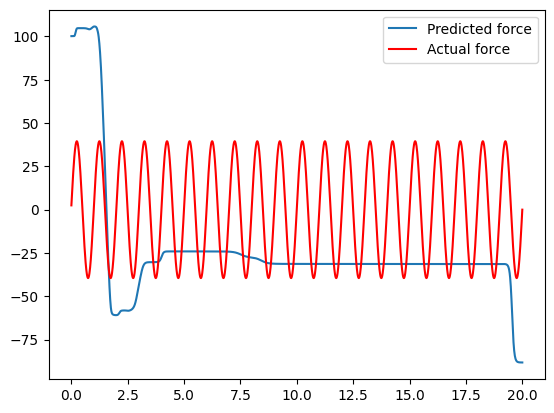

In [53]:
plt.plot(t_train,np.mean(f_pred,axis=(0, 2)),label='Predicted force')
plt.plot(t_train,f_train,'r',label='Actual force')
plt.legend()


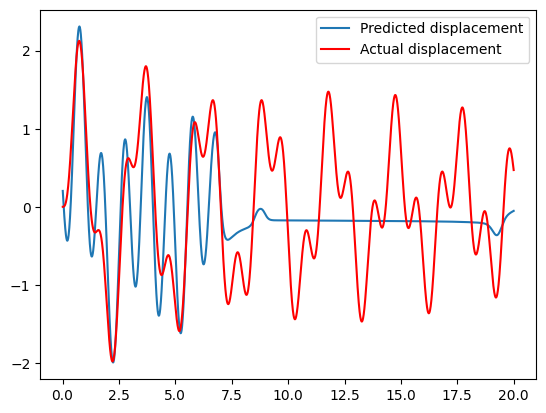

In [54]:
plt.plot(t_train,np.mean(x_pred,axis=(0, 2)),label='Predicted displacement')
plt.plot(t_train,x_train,'r',label='Actual displacement')
plt.legend()


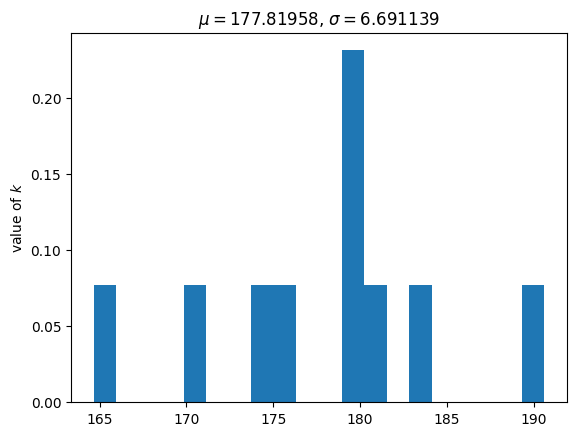

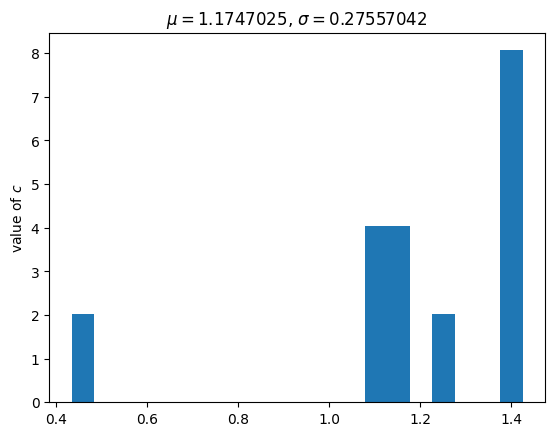

In [55]:
neuq.utils.hist(np.exp(logk_pred).flatten(), name="value of $k$")
neuq.utils.hist(np.exp(logc_pred).flatten(), name="value of $c$")

In [56]:
[a.shape for a in samples]

[(10, 1, 100),
 (10, 100, 128),
 (10, 128, 1),
 (10, 1, 100),
 (10, 1, 128),
 (10, 1, 1),
 (10, 1, 20),
 (10, 20, 20),
 (10, 20, 1),
 (10, 1, 20),
 (10, 1, 20),
 (10, 1, 1),
 (10,),
 (10,)]

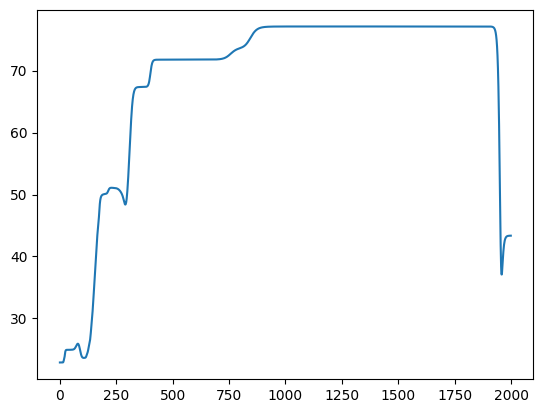

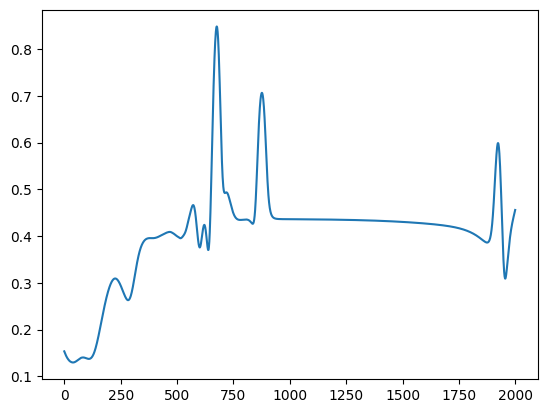

In [57]:
unc_f=np.std(f_pred,axis=0)
plt.plot(unc_f)
plt.figure()
unc_x=np.std(x_pred,axis=0)
plt.plot(unc_x)

In [58]:
Csamp=samples[12]    
Ksamp=samples[13]
C_post=np.exp(np.mean(Csamp))
print("C_true=0.22(Ns/m) and C_post =", C_post) 
K_post=np.exp(np.mean(Ksamp))
print("K_true=10(N/m) and K_post =", K_post) 

C_true=0.22(Ns/m) and C_post = 1.1248162
K_true=10(N/m) and K_post = 177.69304


In [ ]:
# plt.figure
# plt.plot(aa[:,0,0],'r')

In [ ]:
# sio.savemat("G:/My Drive/Python_codes/sdof0.mat", {"x_pred":x_pred, "k":samples[7].flatten(),"c":samples[6].flatten()})

In [32]:
data_to_save = {
   "x_pred":x_pred, "f_pred":f_pred, "c":samples[12].flatten(),"k":samples[13].flatten()
}
file_name = 'output_ukF.mat'
sio.savemat(file_name, data_to_save)